In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install seaborn

In [3]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.2 MB/s eta 0:00:00


Fetched 503 S&P 500 tickers.


Fetching S&P 500 Data:   0%|          | 0/50 [00:00<?, ?it/s]

Data for MMM saved successfully.
Data for AOS saved successfully.
Data for ABT saved successfully.
Data for ABBV saved successfully.
Data for ACN saved successfully.
Data for ADBE saved successfully.
Data for AMD saved successfully.
Data for AES saved successfully.
Data for AFL saved successfully.
Data for A saved successfully.
Data for APD saved successfully.
Data for ABNB saved successfully.
Data for AKAM saved successfully.
Data for ALB saved successfully.
Data for ARE saved successfully.
Data for ALGN saved successfully.
Data for ALLE saved successfully.
Data for LNT saved successfully.
Data for ALL saved successfully.
Data for GOOGL saved successfully.
Data for GOOG saved successfully.
Data for MO saved successfully.
Data for AMZN saved successfully.
Data for AMCR saved successfully.
Data for AMTM saved successfully.
Data for AEE saved successfully.
Data for AEP saved successfully.
Data for AXP saved successfully.
Data for AIG saved successfully.
Data for AMT saved successfully.
D

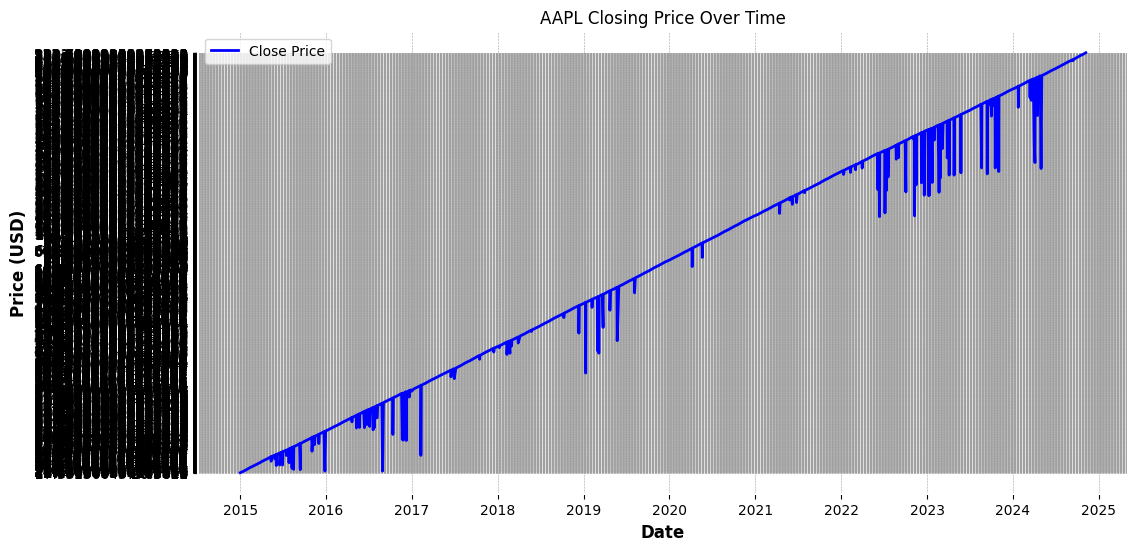

Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
Dropped 1 rows due to invalid dates.
D

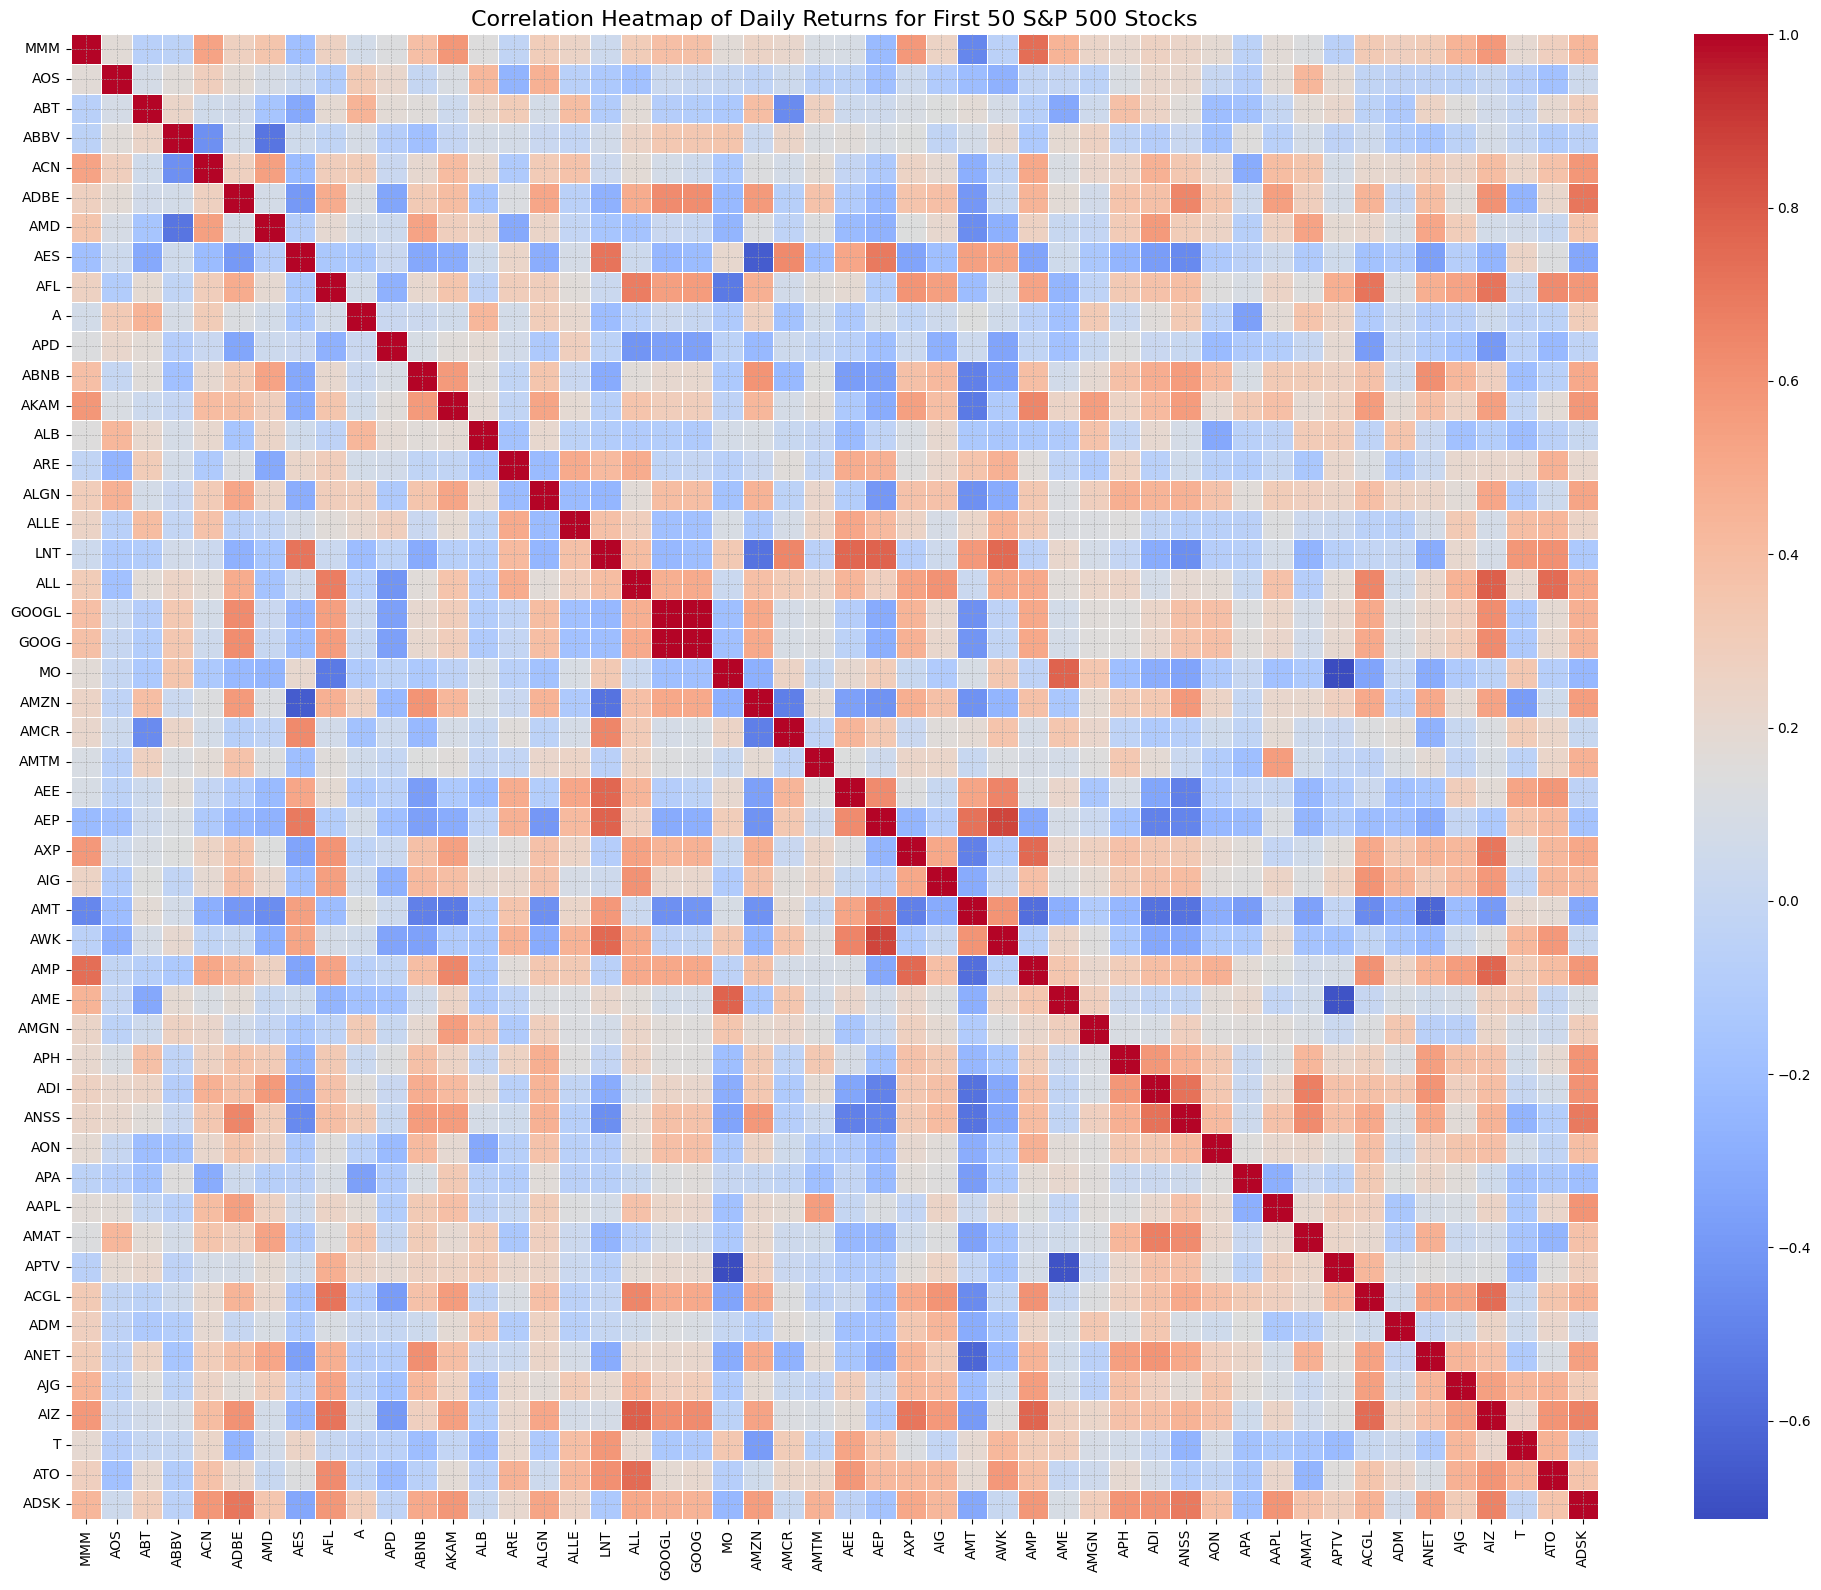

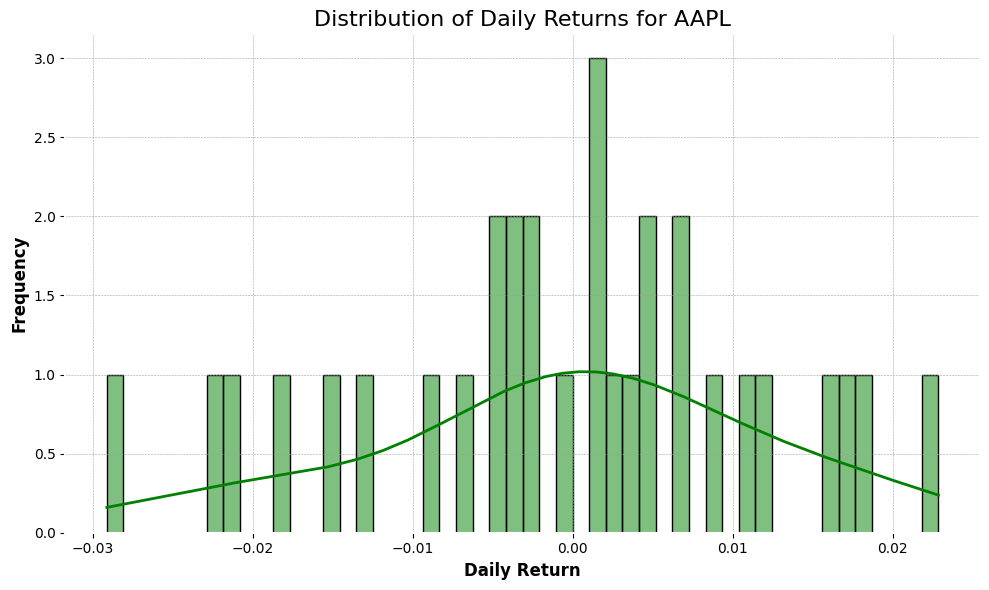

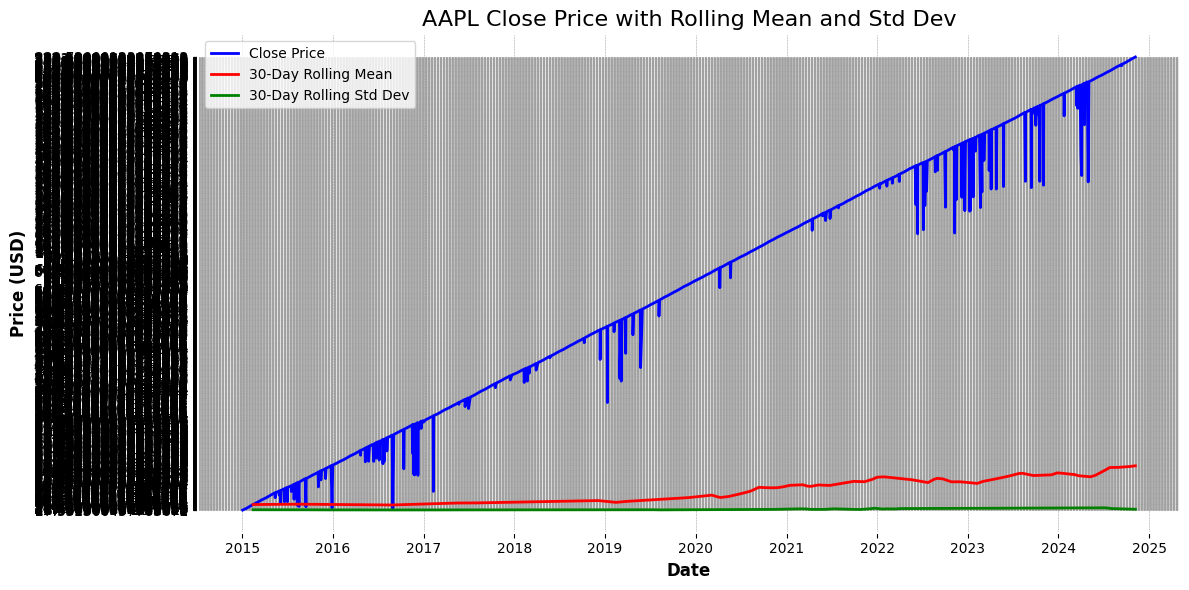

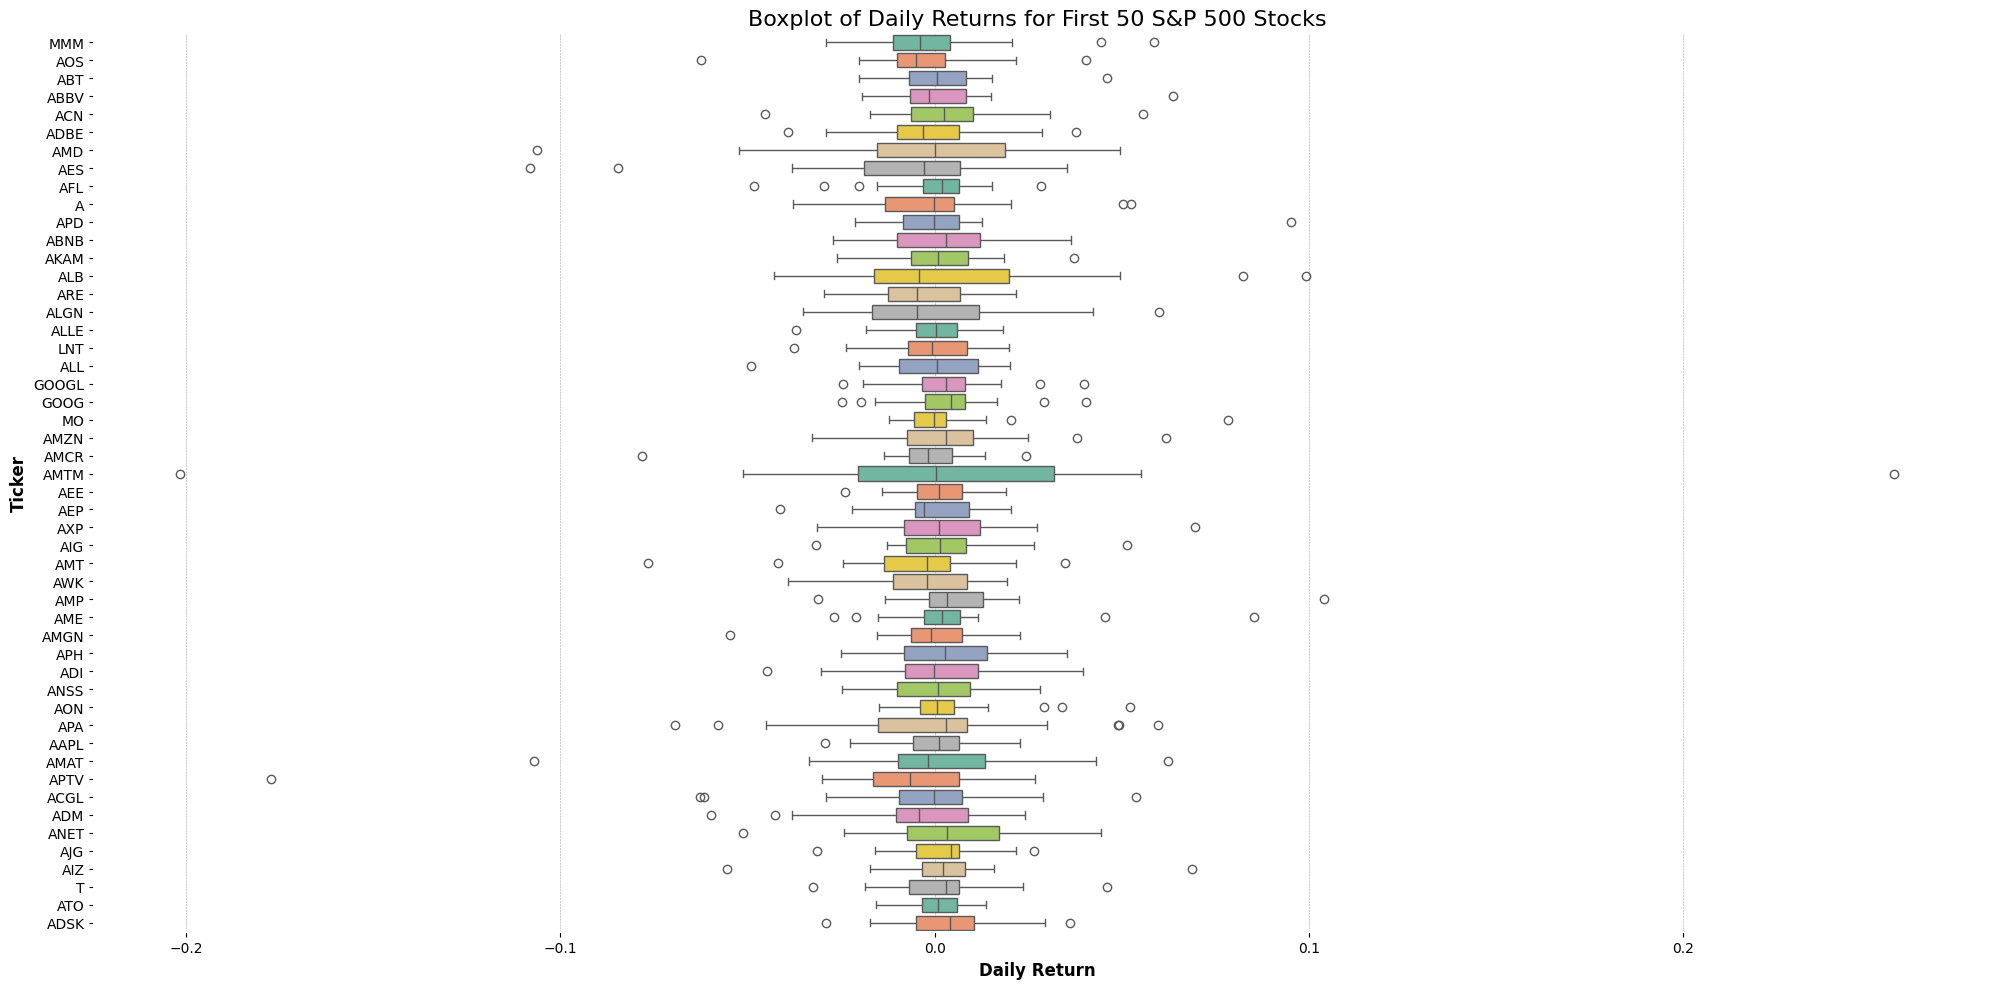

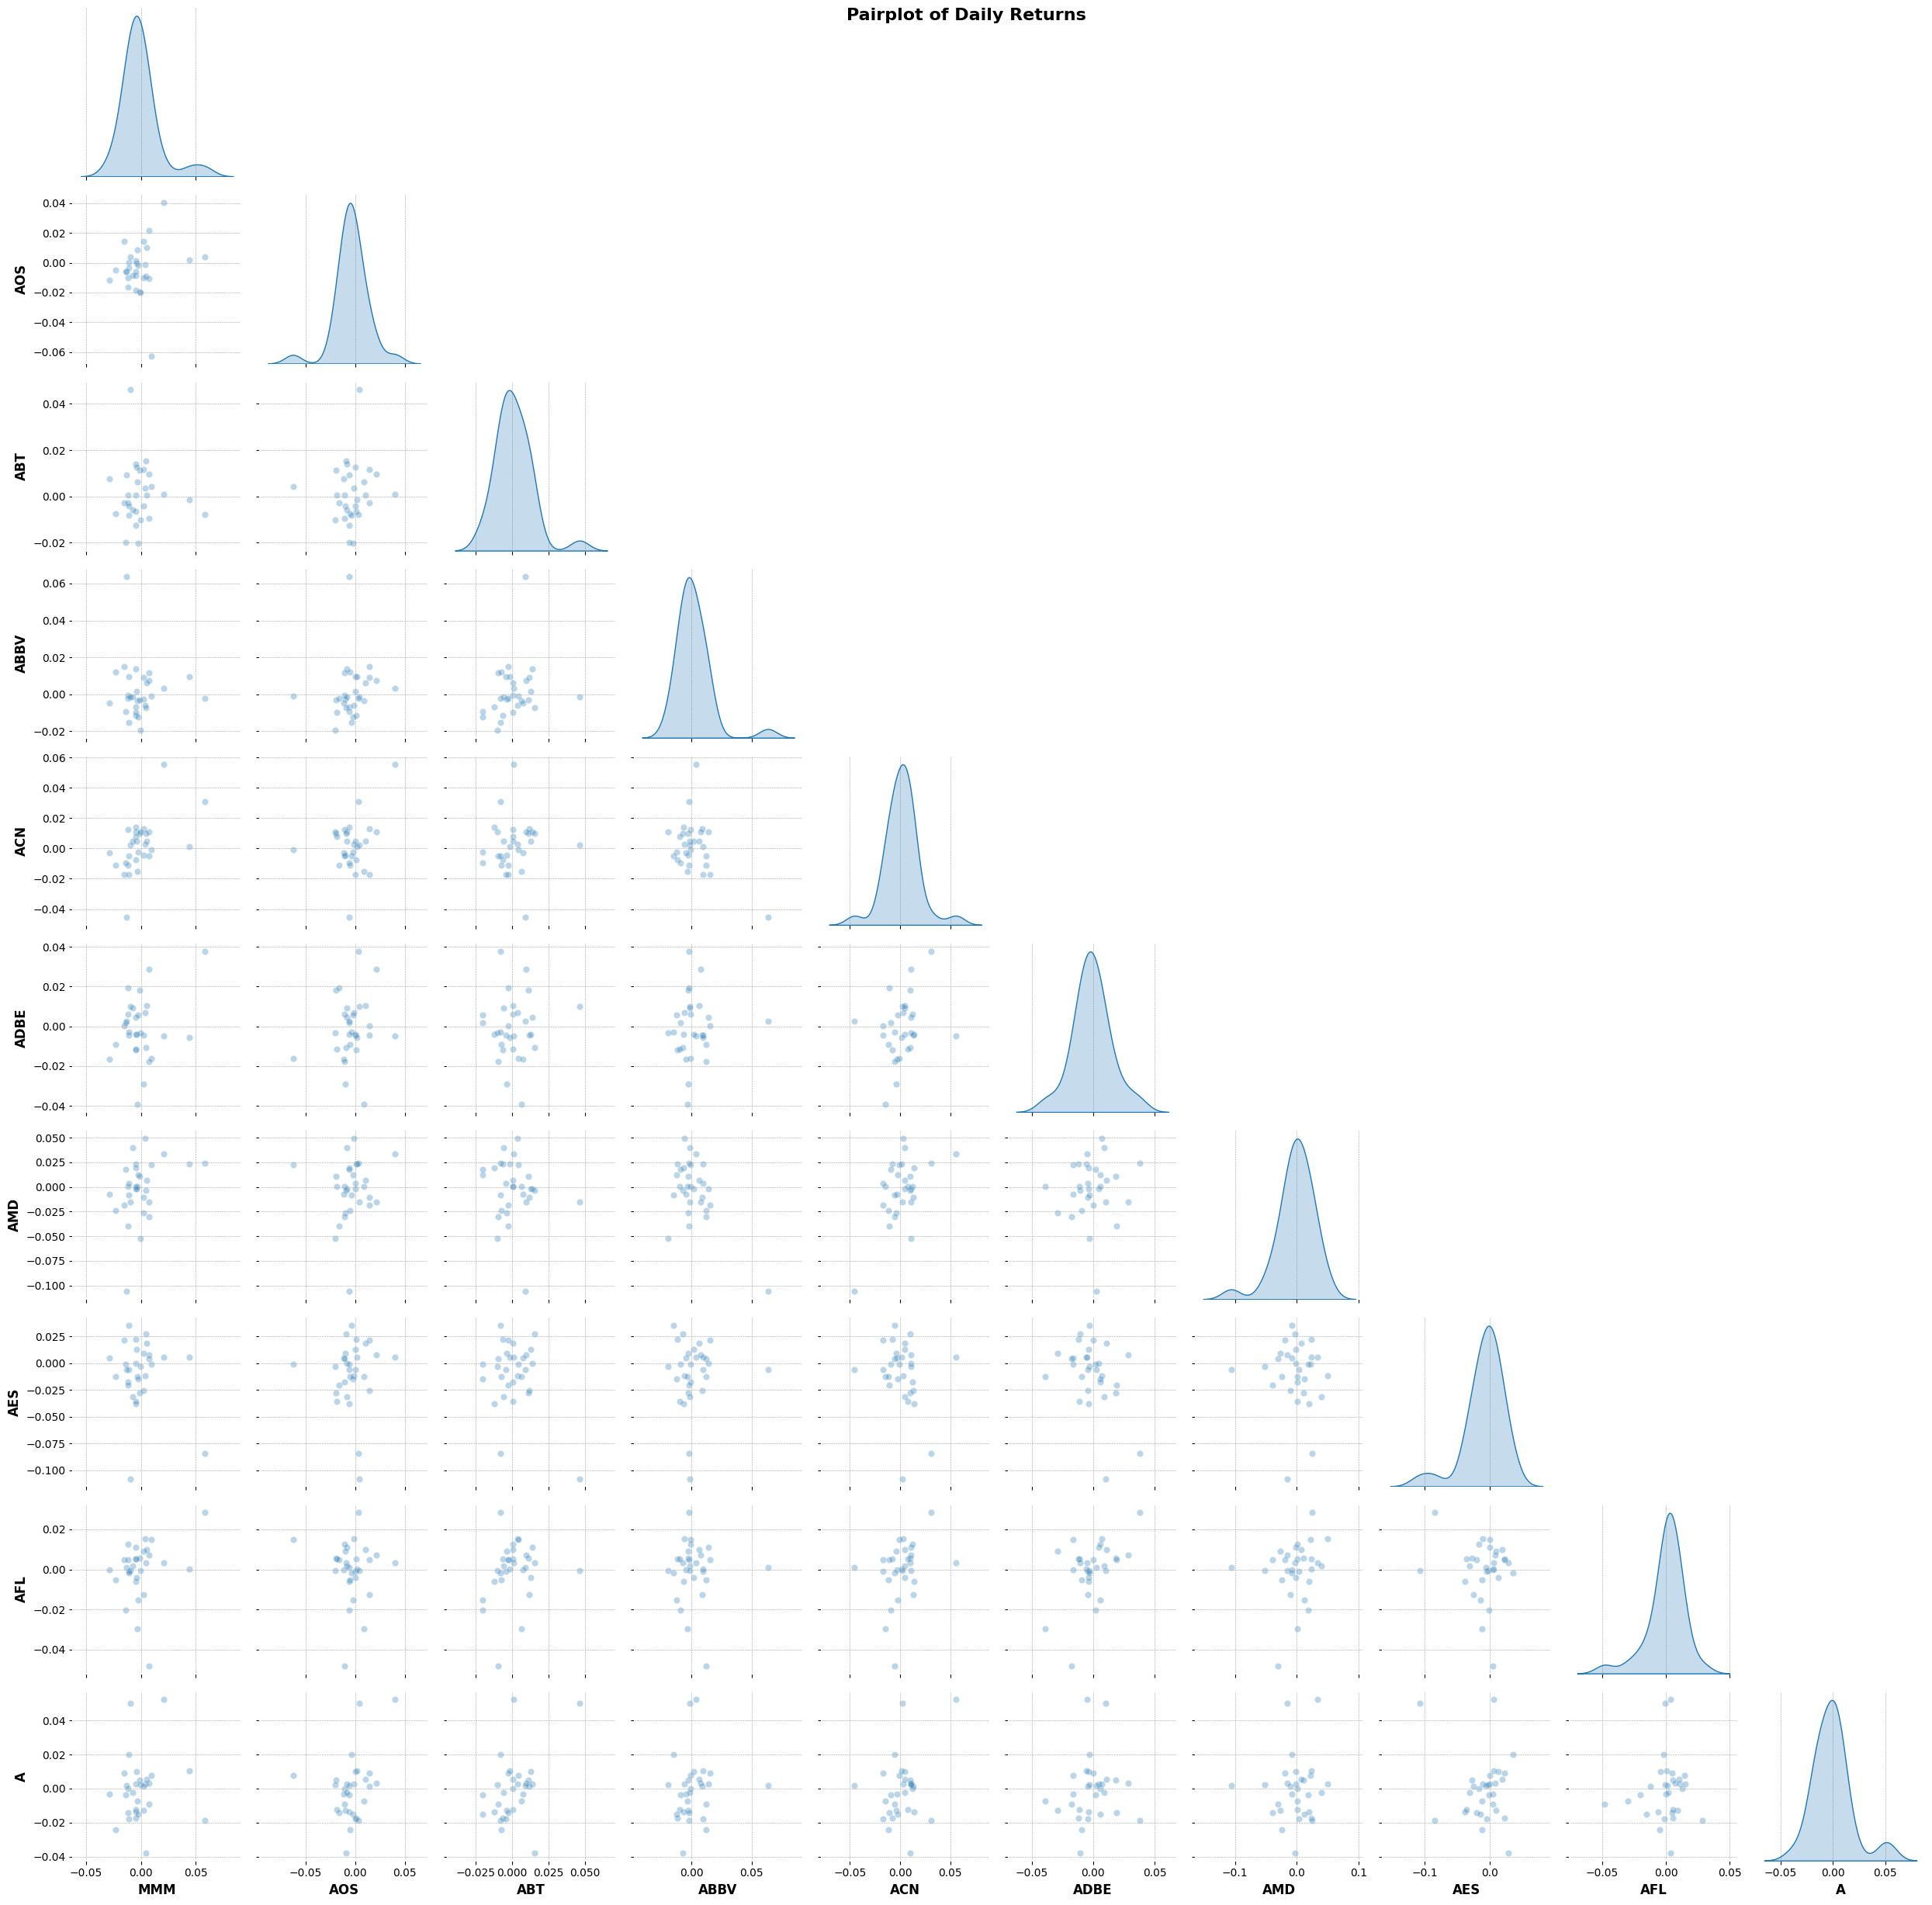


Dropped 1 rows due to invalid dates.


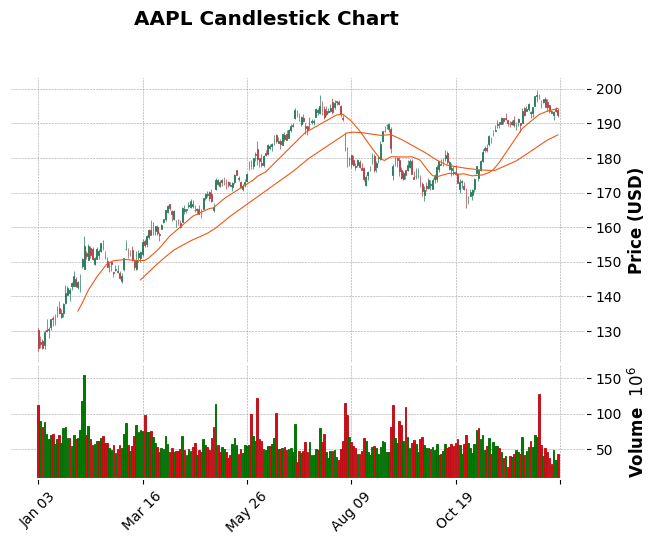

In [8]:
# Week 2: Project Planning and Management

# ================================================================
# 1. Import Required Libraries
# ================================================================
import mplfinance as mpf
import seaborn as sns
import pandas as pd
import yfinance as yf
import os
import datetime
import time
import requests
from tqdm.auto import tqdm  # For progress bars compatible with both Colab and PyCharm
import matplotlib.pyplot as plt

import logging

# ================================================================
# 2. Define Parameters and Directory Structure
# ================================================================

# Define the base directory for data storage
BASE_DIR = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()

# Configure logging
# ===============================================================

# Define log directory
LOG_DIR = os.path.join(BASE_DIR, 'data', 'logs')
os.makedirs(LOG_DIR, exist_ok=True)

# Configure logging
logging.basicConfig(
    filename=os.path.join(LOG_DIR, 'data_fetch.log'),
    filemode='a',
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

# Define paths for raw and processed data
RAW_DATA_DIR = os.path.join(BASE_DIR, 'data', 'raw')
PROCESSED_DATA_DIR = os.path.join(BASE_DIR, 'data', 'processed')

# Create directories if they don't exist
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

# Define date range for historical data
START_DATE = '2015-01-01'
END_DATE = datetime.datetime.now().strftime('%Y-%m-%d')

# ================================================================
# 3. Fetch S&P 500 Tickers from Wikipedia
# ================================================================

def get_sp500_tickers():
    """
    Scrapes the list of S&P 500 companies from Wikipedia and returns a list of ticker symbols.

    Returns:
        tickers (list): List of cleaned ticker symbols.
    """
    try:
        # URL containing the S&P 500 list
        url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

        # Use pandas to read the tables on the Wikipedia page
        tables = pd.read_html(url)

        # The first table typically contains the S&P 500 companies
        sp500_table = tables[0]

        # Extract the 'Symbol' column
        tickers = sp500_table['Symbol'].tolist()

        # Replace '.' with '-' in ticker symbols (e.g., BRK.B -> BRK-B)
        tickers = [ticker.replace('.', '-') for ticker in tickers]

        print(f"Fetched {len(tickers)} S&P 500 tickers.")
        return tickers
    except Exception as e:
        print(f"Error fetching S&P 500 tickers: {e}")
        return []

# ================================================================
# 4. Fetch and Save Historical Stock Data
# ================================================================

def fetch_and_save_stock_data(ticker, start_date, end_date, save_dir):
    """
    Fetches historical stock data for a given ticker and saves it as a CSV file.

    Parameters:
        ticker (str): Stock ticker symbol.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        save_dir (str): Directory path to save the CSV file.

    Returns:
        success (bool): True if data fetched and saved successfully, False otherwise.
    """
    try:
        # Download historical data using yfinance
        stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

        if stock_data.empty:
            logging.warning(f"No data found for {ticker}.")
            print(f"No data found for {ticker}.")
            return False
        else:
            # Reset index to have 'Date' as a column
            stock_data.reset_index(inplace=True)

            # Define the file path
            file_path = os.path.join(save_dir, f"{ticker}.csv")

            # Save to CSV
            stock_data.to_csv(file_path, index=False)
            logging.info(f"Data for {ticker} saved successfully.")
            print(f"Data for {ticker} saved successfully.")
            return True
    except Exception as e:
        logging.error(f"Error fetching data for {ticker}: {e}")
        print(f"Error fetching data for {ticker}: {e}")
        return False

# ================================================================
# 5. Fetch Data for All S&P 500 Companies with Progress Bar
# ================================================================

def fetch_sp500_data(tickers, start_date, end_date, save_dir):
    """
    Fetches historical stock data for a list of tickers and saves each as a CSV file.

    Parameters:
        tickers (list): List of stock ticker symbols.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        save_dir (str): Directory path to save the CSV files.
    """
    # Initialize counters
    total_tickers = len(tickers)
    successful_fetches = 0
    failed_fetches = 0

    # Iterate over tickers with a progress bar
    for ticker in tqdm(tickers, desc="Fetching S&P 500 Data"):
        success = fetch_and_save_stock_data(ticker, start_date, end_date, save_dir)
        if success:
            successful_fetches += 1
        else:
            failed_fetches += 1
        # Sleep to respect API rate limits
        time.sleep(0.1)  # Adjust sleep time as needed

    print(f"\nData fetching completed: {successful_fetches} succeeded, {failed_fetches} failed.")

# ================================================================
# 6. Initial Data Exploration (Sample Visualization)
# ================================================================

def plot_sample_stock(ticker, save_dir):
    """
    Plots the closing price of a sample stock to verify data integrity.

    Parameters:
        ticker (str): Stock ticker symbol.
        save_dir (str): Directory path where the CSV file is saved.
    """
    try:
        # Define the file path
        file_path = os.path.join(save_dir, f"{ticker}.csv")

        if not os.path.exists(file_path):
            logging.warning(f"Data file for {ticker} does not exist.")
            print(f"Data file for {ticker} does not exist.")
            return

        # Load the data
        data = pd.read_csv(file_path)

        # Check if 'Date' column exists
        if 'Date' not in data.columns:
            logging.warning(f"'Date' column not found in {ticker}.csv.")
            print(f"'Date' column not found in {ticker}.csv.")
            return

        # Convert 'Date' column to datetime with UTC, then remove timezone
        data['Date'] = pd.to_datetime(data['Date'], errors='coerce', utc=True).dt.tz_convert(None)

        # Drop rows with NaT in 'Date'
        initial_len = len(data)
        data.dropna(subset=['Date'], inplace=True)
        final_len = len(data)
        if initial_len != final_len:
            logging.info(f"Dropped {initial_len - final_len} rows due to invalid dates for {ticker}.")
            print(f"Dropped {initial_len - final_len} rows due to invalid dates.")

        # Verify 'Close' column exists
        if 'Close' not in data.columns:
            logging.warning(f"'Close' column not found in {ticker}.csv.")
            print(f"'Close' column not found in {ticker}.csv.")
            return

        # Plot the closing price
        plt.figure(figsize=(12,6))
        plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
        plt.title(f"{ticker} Closing Price Over Time")
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.grid(True)
        plt.show()

        logging.info(f"Plotted closing price for {ticker} successfully.")
    except Exception as e:
        logging.error(f"Error plotting data for {ticker}: {e}")
        print(f"Error plotting data for {ticker}: {e}")



# ================================================================
# 7a. Compute Daily Returns for All Stocks
# ================================================================

def compute_daily_returns(tickers, raw_data_dir):
    """
    Computes daily returns for a list of tickers.

    Parameters:
        tickers (list): List of stock ticker symbols.
        raw_data_dir (str): Directory path where the CSV files are saved.

    Returns:
        returns_df (pd.DataFrame): DataFrame containing daily returns of all tickers.
    """
    returns = {}

    for ticker in tickers:
        file_path = os.path.join(raw_data_dir, f"{ticker}.csv")
        if os.path.exists(file_path):
            try:
                data = pd.read_csv(file_path)

                # Ensure 'Date' column exists
                if 'Date' not in data.columns:
                    logging.warning(f"'Date' column not found in {ticker}.csv.")
                    print(f"'Date' column not found in {ticker}.csv.")
                    continue

                # Convert 'Date' column to datetime and remove timezone information
                data['Date'] = pd.to_datetime(data['Date'], errors='coerce', utc=True).dt.tz_convert(None)

                # Drop rows with invalid 'Date'
                initial_len = len(data)
                data.dropna(subset=['Date'], inplace=True)
                final_len = len(data)
                if initial_len != final_len:
                    logging.info(f"Dropped {initial_len - final_len} rows due to invalid dates for {ticker}.")
                    print(f"Dropped {initial_len - final_len} rows due to invalid dates.")

                # Ensure 'Close' column exists
                if 'Close' not in data.columns:
                    logging.warning(f"'Close' column not found in {ticker}.csv.")
                    print(f"'Close' column not found in {ticker}.csv.")
                    continue

                # Convert 'Close' column to numeric, coercing errors to NaN
                data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

                # Drop rows with NaN in 'Close'
                initial_len = len(data)
                data.dropna(subset=['Close'], inplace=True)
                final_len = len(data)
                if initial_len != final_len:
                    logging.info(f"Dropped {initial_len - final_len} rows due to non-numeric 'Close' values for {ticker}.")
                    print(f"Dropped {initial_len - final_len} rows due to non-numeric 'Close' values.")

                # Sort data by 'Date' and set 'Date' as index
                data.sort_values('Date', inplace=True)
                data.set_index('Date', inplace=True)

                # Compute daily returns
                returns[ticker] = data['Close'].pct_change()

                logging.info(f"Computed daily returns for {ticker}.")
            except Exception as e:
                logging.error(f"Error processing data for {ticker}: {e}")
                print(f"Error processing data for {ticker}: {e}")
        else:
            logging.warning(f"Data file for {ticker} does not exist.")
            print(f"Data file for {ticker} does not exist.")

    # Combine all returns into a single DataFrame
    returns_df = pd.DataFrame(returns)

    # Drop rows with NaN values resulting from pct_change()
    returns_df.dropna(inplace=True)

    logging.info("Completed computing daily returns for all tickers.")
    print("Completed computing daily returns for all tickers.")

    return returns_df

# ================================================================
# 7b. Plot Correlation Heatmap
# ================================================================

def plot_correlation_heatmap(returns_df):
    """
    Plots a correlation heatmap of daily returns.

    Parameters:
        returns_df (pd.DataFrame): DataFrame containing daily returns of all tickers.
    """
    plt.figure(figsize=(20, 16))
    correlation_matrix = returns_df.corr()

    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap of Daily Returns for First 50 S&P 500 Stocks', fontsize=16)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# ================================================================
# 7c. Main Execution Flow for Additional Plots
# ================================================================

def main_additional_plots(tickers, raw_data_dir):
    """
    Computes daily returns and generates a correlation heatmap.

    Parameters:
        tickers (list): List of stock ticker symbols.
        raw_data_dir (str): Directory path where the CSV files are saved.
    """
    # Step 1: Compute daily returns
    returns_df = compute_daily_returns(tickers, raw_data_dir)

    # Step 2: Plot correlation heatmap
    plot_correlation_heatmap(returns_df)

    return returns_df  # Return for use in other plots



# ================================================================
# 7d. Plot Distribution of Daily Returns
# ================================================================

def plot_return_distribution(returns_df, ticker):
    """
    Plots the distribution of daily returns for a specific ticker.

    Parameters:
        returns_df (pd.DataFrame): DataFrame containing daily returns of all tickers.
        ticker (str): Stock ticker symbol to plot.
    """
    if ticker not in returns_df.columns:
        print(f"{ticker} not found in returns data.")
        return

    plt.figure(figsize=(10,6))
    sns.histplot(returns_df[ticker], bins=50, kde=True, color='green')
    plt.title(f'Distribution of Daily Returns for {ticker}', fontsize=16)
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ================================================================
# 7e. Plot Rolling Mean and Rolling Standard Deviation
# ================================================================

def plot_rolling_statistics(ticker, raw_data_dir, window=30):
    """
    Plots the rolling mean and rolling standard deviation of a stock's closing price.

    Parameters:
        ticker (str): Stock ticker symbol.
        raw_data_dir (str): Directory path where the CSV file is saved.
        window (int): Window size for rolling calculations.
    """
    try:
        # Define the file path
        file_path = os.path.join(raw_data_dir, f"{ticker}.csv")

        if not os.path.exists(file_path):
            print(f"Data file for {ticker} does not exist.")
            return

        # Load the data
        data = pd.read_csv(file_path)

        # Convert 'Date' column to datetime with UTC, then remove timezone
        data['Date'] = pd.to_datetime(data['Date'], errors='coerce', utc=True).dt.tz_convert(None)

        # Drop rows with NaT in 'Date'
        data.dropna(subset=['Date'], inplace=True)

        # Sort by Date
        data.sort_values('Date', inplace=True)
        data.set_index('Date', inplace=True)

        # Compute rolling statistics
        rolling_mean = data['Close'].rolling(window=window).mean()
        rolling_std = data['Close'].rolling(window=window).std()

        # Plotting
        plt.figure(figsize=(12,6))
        plt.plot(data['Close'], label='Close Price', color='blue')
        plt.plot(rolling_mean, label=f'{window}-Day Rolling Mean', color='red')
        plt.plot(rolling_std, label=f'{window}-Day Rolling Std Dev', color='green')
        plt.title(f'{ticker} Close Price with Rolling Mean and Std Dev', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting rolling statistics for {ticker}: {e}")


# ================================================================
# 7f. Plot Boxplot of Daily Returns for Multiple Stocks
# ================================================================

def plot_boxplot_returns(returns_df):
    """
    Plots a boxplot of daily returns for all tickers.

    Parameters:
        returns_df (pd.DataFrame): DataFrame containing daily returns of all tickers.
    """
    plt.figure(figsize=(20,10))
    sns.boxplot(data=returns_df, orient='h', palette='Set2')
    plt.title('Boxplot of Daily Returns for First 50 S&P 500 Stocks', fontsize=16)
    plt.xlabel('Daily Return')
    plt.ylabel('Ticker')
    plt.tight_layout()
    plt.show()

# ================================================================
# 7g. Plot Pairplot of Daily Returns
# ================================================================

def plot_pairplot_returns(returns_df, selected_tickers=None):
    """
    Plots a pairplot of daily returns for selected tickers.

    Parameters:
        returns_df (pd.DataFrame): DataFrame containing daily returns of all tickers.
        selected_tickers (list, optional): List of tickers to include in the pairplot. Defaults to None (includes all).
    """
    try:
        # Explicitly check if selected_tickers is a non-empty list
        if selected_tickers is not None and len(selected_tickers) > 0:
            data = returns_df[selected_tickers]
        else:
            data = returns_df

        # Limit the number of tickers to prevent overcrowding
        if data.shape[1] > 10:
            print("Too many tickers for a pairplot. Selecting the first 10.")
            data = data.iloc[:, :10]

        sns.pairplot(data, diag_kind='kde', corner=True, plot_kws={'alpha': 0.3})
        plt.suptitle('Pairplot of Daily Returns', fontsize=16)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting pairplot: {e}")

# ================================================================
# 1. Import Additional Required Libraries
# ================================================================

import mplfinance as mpf

# ================================================================
# 7h. Plot Candlestick Chart
# ================================================================

def plot_candlestick(ticker, raw_data_dir, start_date=None, end_date=None):
    """
    Plots a candlestick chart for a given ticker using mplfinance.

    Parameters:
        ticker (str): Stock ticker symbol (e.g., 'AAPL').
        raw_data_dir (str): Directory path where the CSV file is saved.
        start_date (str, optional): Start date in 'YYYY-MM-DD' format. Defaults to None.
        end_date (str, optional): End date in 'YYYY-MM-DD' format. Defaults to None.

    Returns:
        None
    """
    try:
        # Define the file path
        file_path = os.path.join(raw_data_dir, f"{ticker}.csv")

        if not os.path.exists(file_path):
            logging.warning(f"Data file for {ticker} does not exist at path: {file_path}")
            print(f"Data file for {ticker} does not exist at path: {file_path}")
            return

        # Load the data
        data = pd.read_csv(file_path, parse_dates=['Date'])

        # Ensure essential columns exist
        required_columns = {'Date', 'Open', 'High', 'Low', 'Close', 'Volume'}
        missing_columns = required_columns - set(data.columns)
        if missing_columns:
            logging.warning(f"Missing columns {missing_columns} in {ticker}.csv.")
            print(f"Missing columns {missing_columns} in {ticker}.csv.")
            return

        # Convert 'Date' column to datetime and remove timezone information
        data['Date'] = pd.to_datetime(data['Date'], errors='coerce', utc=True).dt.tz_convert(None)

        # Drop rows with NaT in 'Date'
        initial_len = len(data)
        data.dropna(subset=['Date'], inplace=True)
        final_len = len(data)
        if initial_len != final_len:
            logging.info(f"Dropped {initial_len - final_len} rows due to invalid dates for {ticker}.")
            print(f"Dropped {initial_len - final_len} rows due to invalid dates.")

        # Convert OHLC and Volume columns to numeric, coercing errors to NaN
        ohlc_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        data[ohlc_columns] = data[ohlc_columns].apply(pd.to_numeric, errors='coerce')

        # Drop rows with NaN in any OHLC columns
        initial_len = len(data)
        data.dropna(subset=ohlc_columns, inplace=True)
        final_len = len(data)
        if initial_len != final_len:
            logging.info(f"Dropped {initial_len - final_len} rows due to non-numeric OHLC values for {ticker}.")
            print(f"Dropped {initial_len - final_len} rows due to non-numeric OHLC values.")

        # Sort data by 'Date' in ascending order
        data.sort_values('Date', inplace=True)

        # Remove duplicate dates to ensure a monotonic DatetimeIndex
        data = data.drop_duplicates(subset=['Date'])

        # Set 'Date' as index
        data.set_index('Date', inplace=True)

        # Optionally filter by date range
        if start_date:
            try:
                data = data.loc[start_date:]
            except KeyError:
                logging.warning(f"Start date {start_date} not found in data for {ticker}.")
                print(f"Start date {start_date} not found in data for {ticker}.")
        if end_date:
            try:
                data = data.loc[:end_date]
            except KeyError:
                logging.warning(f"End date {end_date} not found in data for {ticker}.")
                print(f"End date {end_date} not found in data for {ticker}.")

        if data.empty:
            print(f"No data available for {ticker} in the specified date range.")
            return

        # Plot candlestick chart using mplfinance
        mpf.plot(data, type='candle', style='charles',
                 title=f'{ticker} Candlestick Chart',
                 ylabel='Price (USD)',
                 volume=True,
                 mav=(20,50))  # Moving averages for 20 and 50 days

        logging.info(f"Plotted candlestick chart for {ticker} successfully.")
    except Exception as e:
        logging.error(f"Error plotting candlestick chart for {ticker}: {e}")
        print(f"Error plotting candlestick chart for {ticker}: {e}")

# ================================================================
# 8. Main Execution Flow
# ================================================================

def main():
    """
    Main function to orchestrate the data fetching and initial exploration.
    including additional high-level plots.
    """
    # Step 1: Get S&P 500 tickers
    tickers = get_sp500_tickers()

    # Proceed only if tickers are fetched successfully
    if not tickers:
        print("No tickers to process. Exiting.")
        return

    # Define the number of stocks to fetch
    NUM_STOCKS = 50

    # Fetch data for the first 50 tickers
    fetch_sp500_data(tickers[:NUM_STOCKS], START_DATE, END_DATE, RAW_DATA_DIR)

    #Step 3: Plot a sample stock's closing price for verification
    sample_ticker = 'AAPL'  # Example: 'AAPL'
    print(f"\nPlotting sample stock: {sample_ticker}")
    plot_sample_stock(sample_ticker, RAW_DATA_DIR)

    # Step 4: Generate additional high-level plots
    returns_df = main_additional_plots(tickers[:NUM_STOCKS], RAW_DATA_DIR)

    """
    Further plots can utilize returns_df
    Example: Plot distribution of a specific stock's returns
    """

    plot_return_distribution(returns_df, 'AAPL') #7d
    print()
    plot_rolling_statistics('AAPL', RAW_DATA_DIR, window=30) #7e
    print()
    plot_boxplot_returns(returns_df) #7f
    print()
    # Example: Select first 10 tickers for pairplot 7g
    selected_tickers = returns_df.columns[:10]
    print()
    plot_pairplot_returns(returns_df, selected_tickers=selected_tickers)
    print()
    plot_candlestick(sample_ticker, RAW_DATA_DIR, start_date='2023-01-01', end_date='2023-12-31') # 7h

# ================================================================
# 8. Run the Main Function
# ================================================================

if __name__ == '__main__':
    main()